# Exploring Market Segments with Classification




## [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing)
(NOTE: The additional social and economic contect attributes were not used for this analysis)

- 1 - **age** (numeric)
- 2 - **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- 3 - **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- 4 - **education** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- 5 - **default**: has credit in default? (categorical: 'no','yes','unknown')
- 6 - **housing**: has housing loan? (categorical: 'no','yes','unknown')
- 7 - **loan**: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:
- 8 - **contact**: contact communication type (categorical: 'cellular','telephone') 
- 9 - **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
- 12 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - **previous**: number of contacts performed before this campaign and for this client (numeric)
- 15 - **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Output variable (desired target):
- 16 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')



In [1]:
# load libraries and functions
from importlib import reload

import functions as fn
import libraries
from libraries import *
import visuals as vs
from visuals import *

%matplotlib inline
reload(libraries)
reload(fn)
reload(vs)
sns.set_style('white')

In [2]:
data = pd.read_csv('bank-full.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# set day to categorical
data.day = data.day.astype('object')

# Month changed to season 
data = fn.add_season(data)

# Change y values to be numeric
data.y = data.y.astype('category').cat.codes

# Bin days into thirds
bins = [0, 10, 20, 31]
labels = [1, 2, 3]
data['day_binned'] = pd.cut(data['day'], bins=bins, labels=labels)

data.day_binned = data.day_binned.astype('object')


# Previously Contacted Subgroups

In [31]:
# majority - 36954 - not previously contacted
# Only 8257 previously contacted 
len(data.loc[data['previous'] > 0]) # -1 means client not contacted

data.loc[data['previous'] == 0, 'first'] = 'no'
data.loc[data['previous'] > 0, 'first'] = 'yes'

data.groupby(['y', 'first']).mean()

age      balance        day    duration  campaign  \
y   first                                                            
no  no     40.903307  1280.229014  16.220197  222.165326  2.980637   
    yes    40.499055  1427.837059  14.159320  215.990239  2.136650   
yes no     41.221336  1701.310579  15.403664  610.496749  2.339835   
    yes    42.467192  1987.159055  14.722310  407.259843  1.787927   

                pdays  previous  
y   first                        
no  no      -1.000000  0.000000  
    yes    234.191436  3.156014  
yes no      -1.000000  0.000000  
    yes    192.521785  3.249344

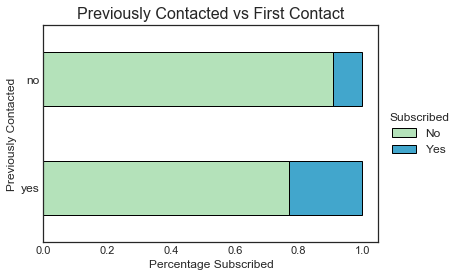

In [32]:
stacked_bar(data, 'first', 'y', normalize=True,
            legend_label=['No', 'Yes'], title = 'Previously Contacted vs First Contact',
           xlabel='Percentage Subscribed', ylabel='Previously Contacted',
           legend_title='Subscribed')

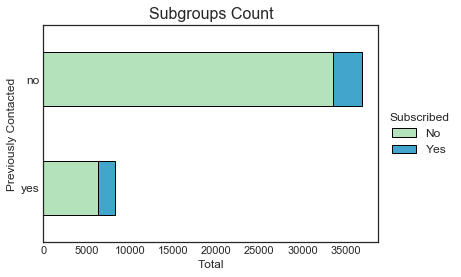

In [33]:
stacked_bar(data, 'first', 'y', normalize=False,
            legend_label=['No', 'Yes'], title = 'Subgroups Count',
           xlabel='Total', ylabel='Previously Contacted',
            legend_title='Subscribed')

In [7]:
# Create data subsets based on whether customers 
# were previously contacted or not
contacted = data.loc[data['previous'] > 0].copy()
first = data.loc[data.previous == 0].copy()
first.drop(['poutcome', 'pdays', 'previous', 'duration', 'day', 'first'], axis=1, inplace=True)
first.day_binned = first.day_binned.astype('object')

In [8]:
#fn.save_data(first, 'first.csv')

# Feature Importance

### Logistic Regression

In [9]:
# One hot encode categories
onehot = fn.one_hot_df(first, target='y')

# Scale dataset 
scaler = StandardScaler()
onehot_z = scaler.fit_transform(onehot)

X = pd.DataFrame(onehot_z)
X.columns = onehot.columns
y = pd.DataFrame(first.y)
y.columns = ['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
logreg = LogisticRegression(fit_intercept = False, 
                            solver='lbfgs', 
                            class_weight='balanced')

#Probability scores for test set
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

Normalized confusion matrix
[[0.51256102 0.48743898]
 [0.22261905 0.77738095]]


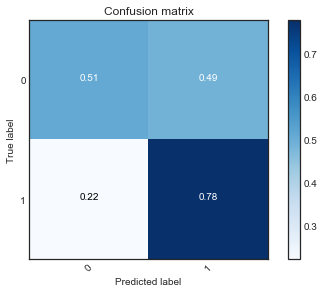

In [11]:
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_hat_test)
vs.plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True);

In [12]:
def get_features(model, features):
    coef = pd.DataFrame(model.coef_, columns=features)
    coef = pd.DataFrame(coef.stack()).reset_index().drop('level_0', axis=1, inplace=False)
    coef.rename(columns={'level_1': 'features', 0:'coefficients'}, inplace=True)
    
    fig = plt.figure(figsize=(14,8))
    feat_imp = [tuple(r) for r in coef[['features', 'coefficients']].values]
    feat_imp.sort(key=lambda tup: tup[1]) 
    plt.bar(range(len(feat_imp)), [val[1] for val in feat_imp], align='center')
    plt.xticks(range(len(feat_imp)), [val[0] for val in feat_imp], size=13)
    plt.xticks(rotation=70)
    plt.title('Influence on Subscription', size=18)
    plt.show()

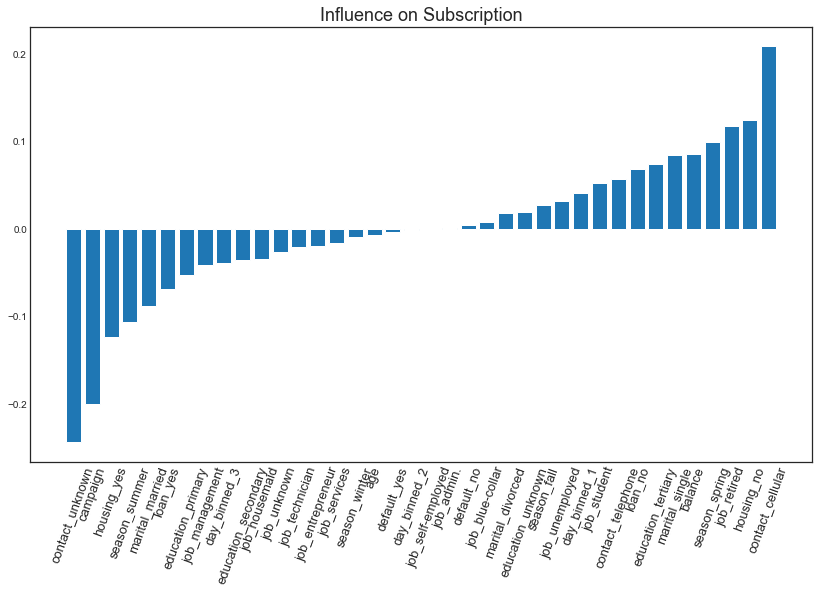

In [13]:
get_features(logreg, list(onehot.columns))

## Classifying Subscribers

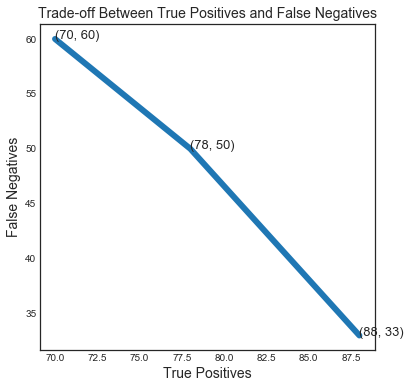

In [14]:
model_metrics = pd.read_csv('range_classifiers.csv', index_col=0)

A = model_metrics.recall
B = model_metrics.tnr


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)


plt.plot(A,B, lw=6)
for xy in zip(A, B):                                       
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', size=13) 

plt.ylabel('False Negatives', size=14)
plt.xlabel('True Positives', size=14)
plt.title('Trade-off Between True Positives and False Negatives', size=14)
plt.show()


# Relevant Features

### Seasonality

Seasonality in subscriptions is visualized below (months were grouped into seasons above, see functions.py).

In [15]:
data = pd.read_csv('bank-full.csv', sep=';')
subscriptions = data.groupby('month')['y'].value_counts(normalize=False).unstack() 
sum_yes = sum(subscriptions.yes)
sum_no = sum(subscriptions.no)

# Yes subscriptions for month: Total yes subscriptions 
subscriptions['yes_ratio'] = subscriptions.yes / sum_yes

# Yes subscriptions for month: No subscriptions for month
subscriptions['yes_to_no_ratio'] = subscriptions.yes / subscriptions.no

# Yes subscriptions for month: Calls for month
subscriptions['yes_to_total_ratio'] = subscriptions.yes / (subscriptions.yes + subscriptions.no)

# Total calls for month: Total calls
subscriptions['calls_ratio'] = (subscriptions.yes + subscriptions.no) / (sum_yes + sum_no)

subscriptions = subscriptions.loc[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
                                      'oct', 'nov', 'dec'], :]
subscriptions.reset_index(inplace=True)
subscriptions


y,month,no,yes,yes_ratio,yes_to_no_ratio,yes_to_total_ratio,calls_ratio
0,jan,1261,142,0.026848,0.112609,0.101212,0.031032
1,feb,2208,441,0.083381,0.199728,0.166478,0.058592
2,mar,229,248,0.046890,1.082969,0.519916,0.010551
3,apr,2355,577,0.109094,0.245011,0.196794,0.064851
4,may,12841,925,0.174891,0.072035,0.067195,0.304483
5,jun,4795,546,0.103233,0.113869,0.102228,0.118135
6,jul,6268,627,0.118548,0.100032,0.090935,0.152507
7,aug,5559,688,0.130081,0.123763,0.110133,0.138174
8,sep,310,269,0.050860,0.867742,0.464594,0.012807
9,oct,415,323,0.061070,0.778313,0.437669,0.016323


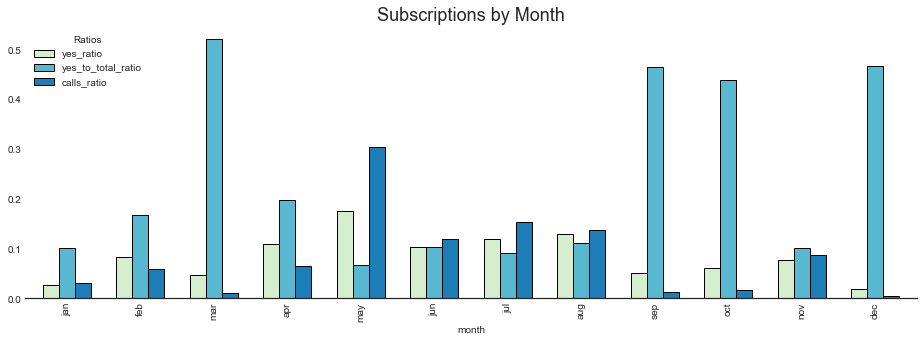

In [16]:
# while less calls are made in fall and winter, the subscriptions: calls ratio is high
# indicating a better hit rate during these months. However, the spring/ summer months
# receive an overall higher number of subscriptions, despite only 50% of the calls 
# resulting in a subscription (lower hit ratio, higher overall number of subscriptions).
plt.style.use('seaborn-white')

subscriptions.plot(x="month", y=['yes_ratio',
       'yes_to_total_ratio', 'calls_ratio'], kind="bar",
        colormap=ListedColormap(sns.color_palette("GnBu", 4)),
                  figsize=(16,5), edgecolor = "black",
                  width=0.65)
sns.despine(left=True, bottom=False)
plt.legend(title='Ratios')
plt.title('Subscriptions by Month', size=18);


In [17]:
daily = data.groupby('day')['y'].value_counts(normalize=False).unstack() 
sum_yes = sum(daily.yes)
sum_no = sum(daily.no)

# Yes subscriptions for day: Total yes subscriptions 
daily['yes_ratio'] = daily.yes / sum_yes

# Yes subscriptions for day: No subscriptions for day
daily['yes_to_no_ratio'] = daily.yes / daily.no

# Yes subscriptions for day: Calls for day
daily['yes_to_total_ratio'] = daily.yes / (daily.yes + daily.no)

# Total calls for day: Total day
daily['calls_ratio'] = (daily.yes + daily.no) / (sum_yes + sum_no)

#subscriptions = subscriptions.loc[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
#                                      'oct', 'nov', 'dec'], :]

daily.reset_index(inplace=True)
daily

y,day,no,yes,yes_ratio,yes_to_no_ratio,yes_to_total_ratio,calls_ratio
0,1,232,90,0.017016,0.387931,0.279503,0.007122
1,2,1111,182,0.034411,0.163816,0.140758,0.028599
2,3,901,178,0.033655,0.197558,0.164968,0.023866
3,4,1215,230,0.043486,0.189300,0.159170,0.031961
4,5,1695,215,0.040650,0.126844,0.112565,0.042246
5,6,1751,181,0.034222,0.103370,0.093685,0.042733
6,7,1660,157,0.029684,0.094578,0.086406,0.040189
7,8,1641,201,0.038003,0.122486,0.109121,0.040742
8,9,1382,179,0.033844,0.129522,0.114670,0.034527
9,10,403,121,0.022878,0.300248,0.230916,0.011590


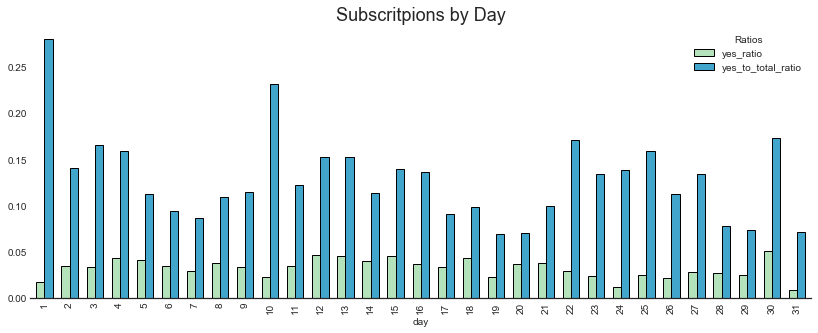

In [18]:
daily.plot(x="day", y=['yes_ratio', 'yes_to_total_ratio'], kind="bar",
        colormap=ListedColormap(sns.color_palette("GnBu", 2)),
                  figsize=(14,5), edgecolor = "black",
                  width=0.65)
sns.despine(left=True, bottom=False)
plt.title('Subscritpions by Day', size=18)
plt.legend(title='Ratios');


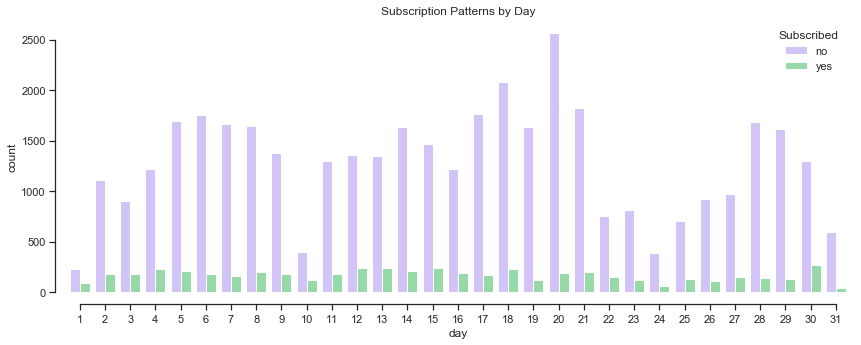

In [19]:
vs.nested_bar(data, x='day', hue='y', 
           title='Subscription Patterns by Day',
           legend_title='Subscribed',
           legend_labels=['no', 'yes'])

## Subscriptions by Group

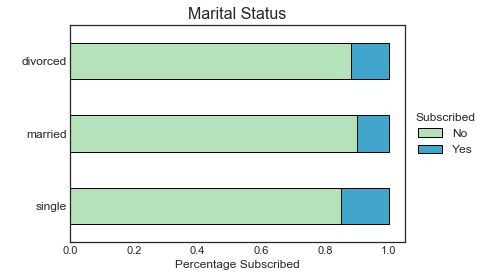

In [20]:
stacked_bar(data, 'marital', 'y', normalize=True,
            legend_label=['No', 'Yes'], title = 'Marital Status',
           xlabel='Percentage Subscribed', ylabel=' ',
           legend_title='Subscribed')

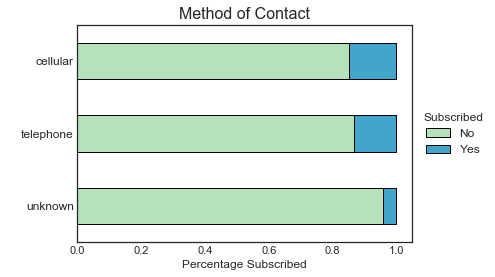

In [21]:
stacked_bar(data, 'contact', 'y', normalize=True,
            legend_label=['No', 'Yes'], title = 'Method of Contact',
           xlabel='Percentage Subscribed', ylabel=' ',
           legend_title='Subscribed')

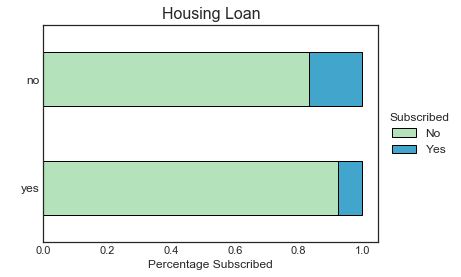

In [22]:
stacked_bar(data, 'housing', 'y', normalize=True,
            legend_label=['No', 'Yes'], title = 'Housing Loan',
           xlabel='Percentage Subscribed', ylabel=' ',
           legend_title='Subscribed')

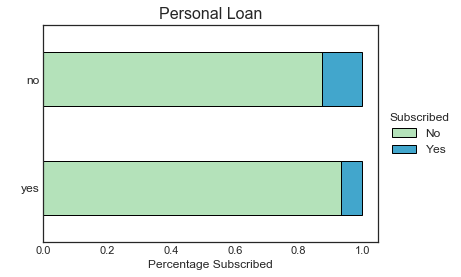

In [23]:
stacked_bar(data, 'loan', 'y', normalize=True,
            legend_label=['No', 'Yes'], title = 'Personal Loan',
           xlabel='Percentage Subscribed', ylabel=' ',
           legend_title='Subscribed')

In [24]:
features_keep = ['contact_unknown', 'housing_no','age', 'balance', 'campaign',
                 'season_summer','marital_married','contact_cellular', 'season_spring',
                 'season_fall','housing_yes','day_binned_3', 'loan_no', 'marital_single']

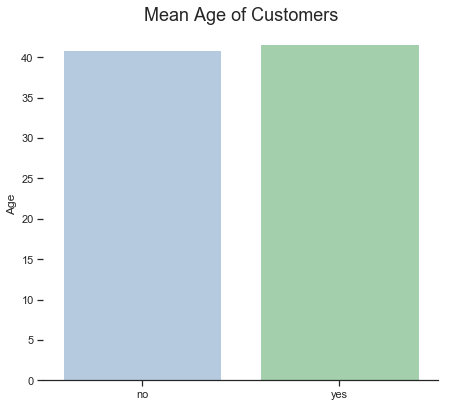

In [25]:
sns.set(style="ticks", palette="husl")
g = sns.catplot(x="y", y="age",
                data=data, saturation=.5,
                 kind="bar", ci=None, aspect=.6, palette=["b", "g"])
(g.set_axis_labels("", "Age")
   .despine(left=True));

fig = plt.gcf()
fig.set_size_inches(8,6)
plt.title("Mean Age of Customers", size=18);

In [26]:
data.groupby('y')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
no,39922.0,40.838986,10.172662,18.0,33.0,39.0,48.0,95.0
yes,5289.0,41.670070,13.497781,18.0,31.0,38.0,50.0,95.0


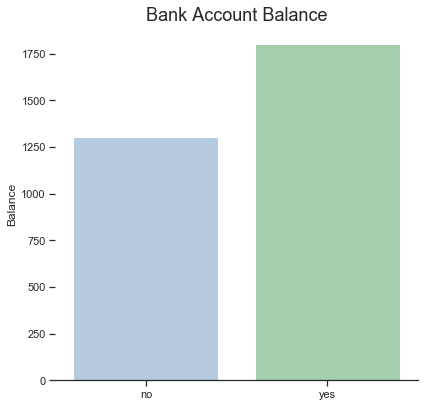

In [27]:
sns.set(style="ticks", palette="husl")
g = sns.catplot(x="y", y="balance",
                data=data, saturation=.5,
                 kind="bar", ci=None, aspect=.6, palette=["b", "g"])
(g.set_axis_labels("", "Balance")
   #.set_xticklabels(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
   #    'nov', 'oct', 'sep'])
   #.set_titles("Contact Method and Duration of Call")
   #.set(ylim=(0, 1.2))
   .despine(left=True));

fig = plt.gcf()
fig.set_size_inches(8,6)
plt.title("Bank Account Balance", size=18);

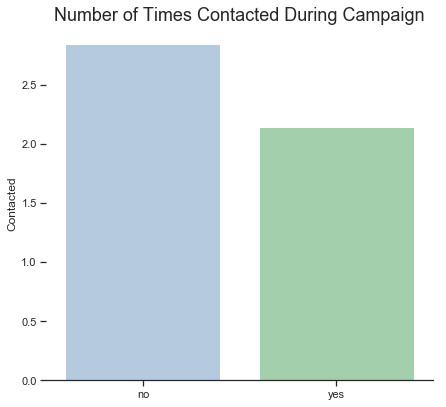

In [28]:
sns.set(style="ticks", palette="husl")
g = sns.catplot(x="y", y="campaign",
                data=data, saturation=.5,
                 kind="bar", ci=None, aspect=.6, palette=["b", "g"])
(g.set_axis_labels("", "Contacted")
   #.set_xticklabels(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
   #    'nov', 'oct', 'sep'])
   #.set_titles("Contact Method and Duration of Call")
   #.set(ylim=(0, 1.2))
   .despine(left=True));

fig = plt.gcf()
fig.set_size_inches(8,6)
plt.title("Number of Times Contacted During Campaign", size=18);

# Follow Up Questions:
---------------------------------------------------

- Describe most likely subscribers for each season (do they differ)?
- Are there different clusters of subscribers?
- If so, are there differences between these clusters in terms of how likely they are to subscribe?


References

Feature Engineering: https://adataanalyst.com/machine-learning/comprehensive-guide-feature-engineering/

Seasonality: https://www.analyticsvidhya.com/blog/2013/10/methods-tackle-seasonal-models/